In [1]:
get_ipython().run_cell_magic('capture', 'cont', '!pip install db-dtypes\n')

In [2]:
cont.show()

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

In [4]:
import os
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics

In [5]:
import statsmodels.api as sm
import itertools

CONFIGURE THE BIGQUERY SETTINGS

In [6]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [7]:
#obtaining the unemployment data
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [8]:
# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
data = query_job.to_dataframe()
#data['date']= pd.to_datetime(data['date'])
data.head()

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
0,f013068de98db1470bd986137a0c6d23,20220416,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,<NA>,14,...,<NA>,<NA>,0,0,0,11,0,0,<NA>,<NA>
1,21957d5517323845818d87623589e1ba,20220319,12,18089,10400,"Census Tract 104, Lake County, Indiana",111,0,<NA>,108,...,76,35,0,0,0,<NA>,<NA>,0,0,0
2,6a5609f385912113b6f1014b958ed748,20220326,13,18089,11500,"Census Tract 115, Lake County, Indiana",39,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,39,0,0,0,0
3,46b2882ec4c373527ec33f7bd4f1388d,20220716,29,18089,20700,"Census Tract 207, Lake County, Indiana",14,0,<NA>,<NA>,...,<NA>,<NA>,0,0,<NA>,10,0,0,<NA>,<NA>
4,37495d17e82f7df326bfc2c4c090f7b7,20220409,15,18089,21900,"Census Tract 219, Lake County, Indiana",155,0,<NA>,69,...,90,65,0,0,0,135,<NA>,<NA>,<NA>,<NA>


In [9]:
#obtaining the submission file
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [10]:
# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
submit = query_job.to_dataframe()
#data['date']= pd.to_datetime(data['date'])
submit.head()

,uu_id,week_number
0,5bf51fc2e162d6faf9e3cf79e4198378,44
1,420b44cc7e3f55d738df565421e59941,44
2,e39c66ecceec76ee8f9f811fa4a2d246,44
3,a90462cd11ae4e43144239bf7c4828a4,44
4,8b20a6749088c7ff1237983076ebfeaa,44


In [11]:
data.info()   #Feature Matrix
#X = data.drop("date",1)
#y = data["wind_speed"]          #Target Variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16833 entries, 0 to 16832
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uu_id                   16833 non-null  object
 1   timeperiod              16833 non-null  Int64 
 2   week_number             16833 non-null  Int64 
 3   countyfips              16833 non-null  Int64 
 4   tract                   16833 non-null  Int64 
 5   tract_name              16833 non-null  object
 6   total_claims            16833 non-null  Int64 
 7   edu_8th_or_less         13748 non-null  Int64 
 8   edu_grades_9_11         5942 non-null   Int64 
 9   edu_hs_grad_equiv       6036 non-null   Int64 
 10  edu_post_hs             3246 non-null   Int64 
 11  edu_unknown             12031 non-null  Int64 
 12  top_category_employer1  16833 non-null  object
 13  top_category_employer2  16833 non-null  object
 14  top_category_employer3  16833 non-null  object
 15  ge

In [12]:
submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uu_id        525 non-null    object
 1   week_number  525 non-null    Int64 
dtypes: Int64(1), object(1)
memory usage: 8.8+ KB


dropping duplicate rows in the data

In [13]:
data.drop_duplicates(inplace=True, ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13977 entries, 0 to 13976
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uu_id                   13977 non-null  object
 1   timeperiod              13977 non-null  Int64 
 2   week_number             13977 non-null  Int64 
 3   countyfips              13977 non-null  Int64 
 4   tract                   13977 non-null  Int64 
 5   tract_name              13977 non-null  object
 6   total_claims            13977 non-null  Int64 
 7   edu_8th_or_less         11445 non-null  Int64 
 8   edu_grades_9_11         4893 non-null   Int64 
 9   edu_hs_grad_equiv       5082 non-null   Int64 
 10  edu_post_hs             2672 non-null   Int64 
 11  edu_unknown             10055 non-null  Int64 
 12  top_category_employer1  13977 non-null  object
 13  top_category_employer2  13977 non-null  object
 14  top_category_employer3  13977 non-null  object
 15  ge

unique number of ID in the data

In [14]:
data.uu_id.unique().size

525

replace all na values with 0

In [15]:
data.fillna(0, inplace=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13977 entries, 0 to 13976
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uu_id                   13977 non-null  object
 1   timeperiod              13977 non-null  Int64 
 2   week_number             13977 non-null  Int64 
 3   countyfips              13977 non-null  Int64 
 4   tract                   13977 non-null  Int64 
 5   tract_name              13977 non-null  object
 6   total_claims            13977 non-null  Int64 
 7   edu_8th_or_less         13977 non-null  Int64 
 8   edu_grades_9_11         13977 non-null  Int64 
 9   edu_hs_grad_equiv       13977 non-null  Int64 
 10  edu_post_hs             13977 non-null  Int64 
 11  edu_unknown             13977 non-null  Int64 
 12  top_category_employer1  13977 non-null  object
 13  top_category_employer2  13977 non-null  object
 14  top_category_employer3  13977 non-null  object
 15  ge

number of weeks in the data for a random ID

In [17]:
test=data[data['uu_id']=='bbcb018f0e5e49e13636f6e78ce9f60f']
len(test)

35

convert the timeperiod column to datetime

In [18]:
data['timeperiod']= pd.to_datetime(data['timeperiod'], format='%Y%m%d')

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_16700/3933921817.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = data.corr()


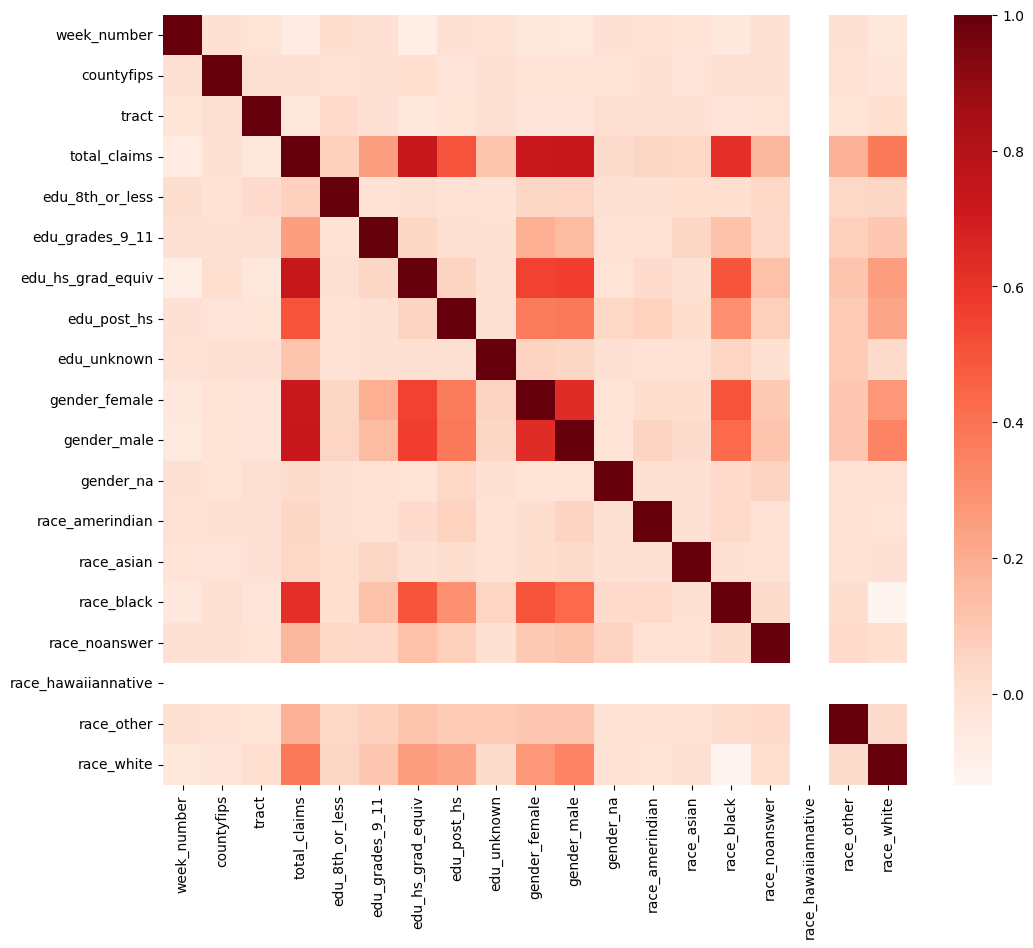

In [19]:
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor,  cmap=plt.cm.Reds)
plt.show()

In [20]:
#Correlation with output variable
cor_target = abs(cor["total_claims"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]
print(relevant_features)

total_claims         1.000000
edu_grades_9_11      0.250325
edu_hs_grad_equiv    0.736854
edu_post_hs          0.501751
gender_female        0.721260
gender_male          0.730403
race_black           0.623235
race_white           0.379260
Name: total_claims, dtype: float64


In [21]:
columns_rel = relevant_features.index.to_list()

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

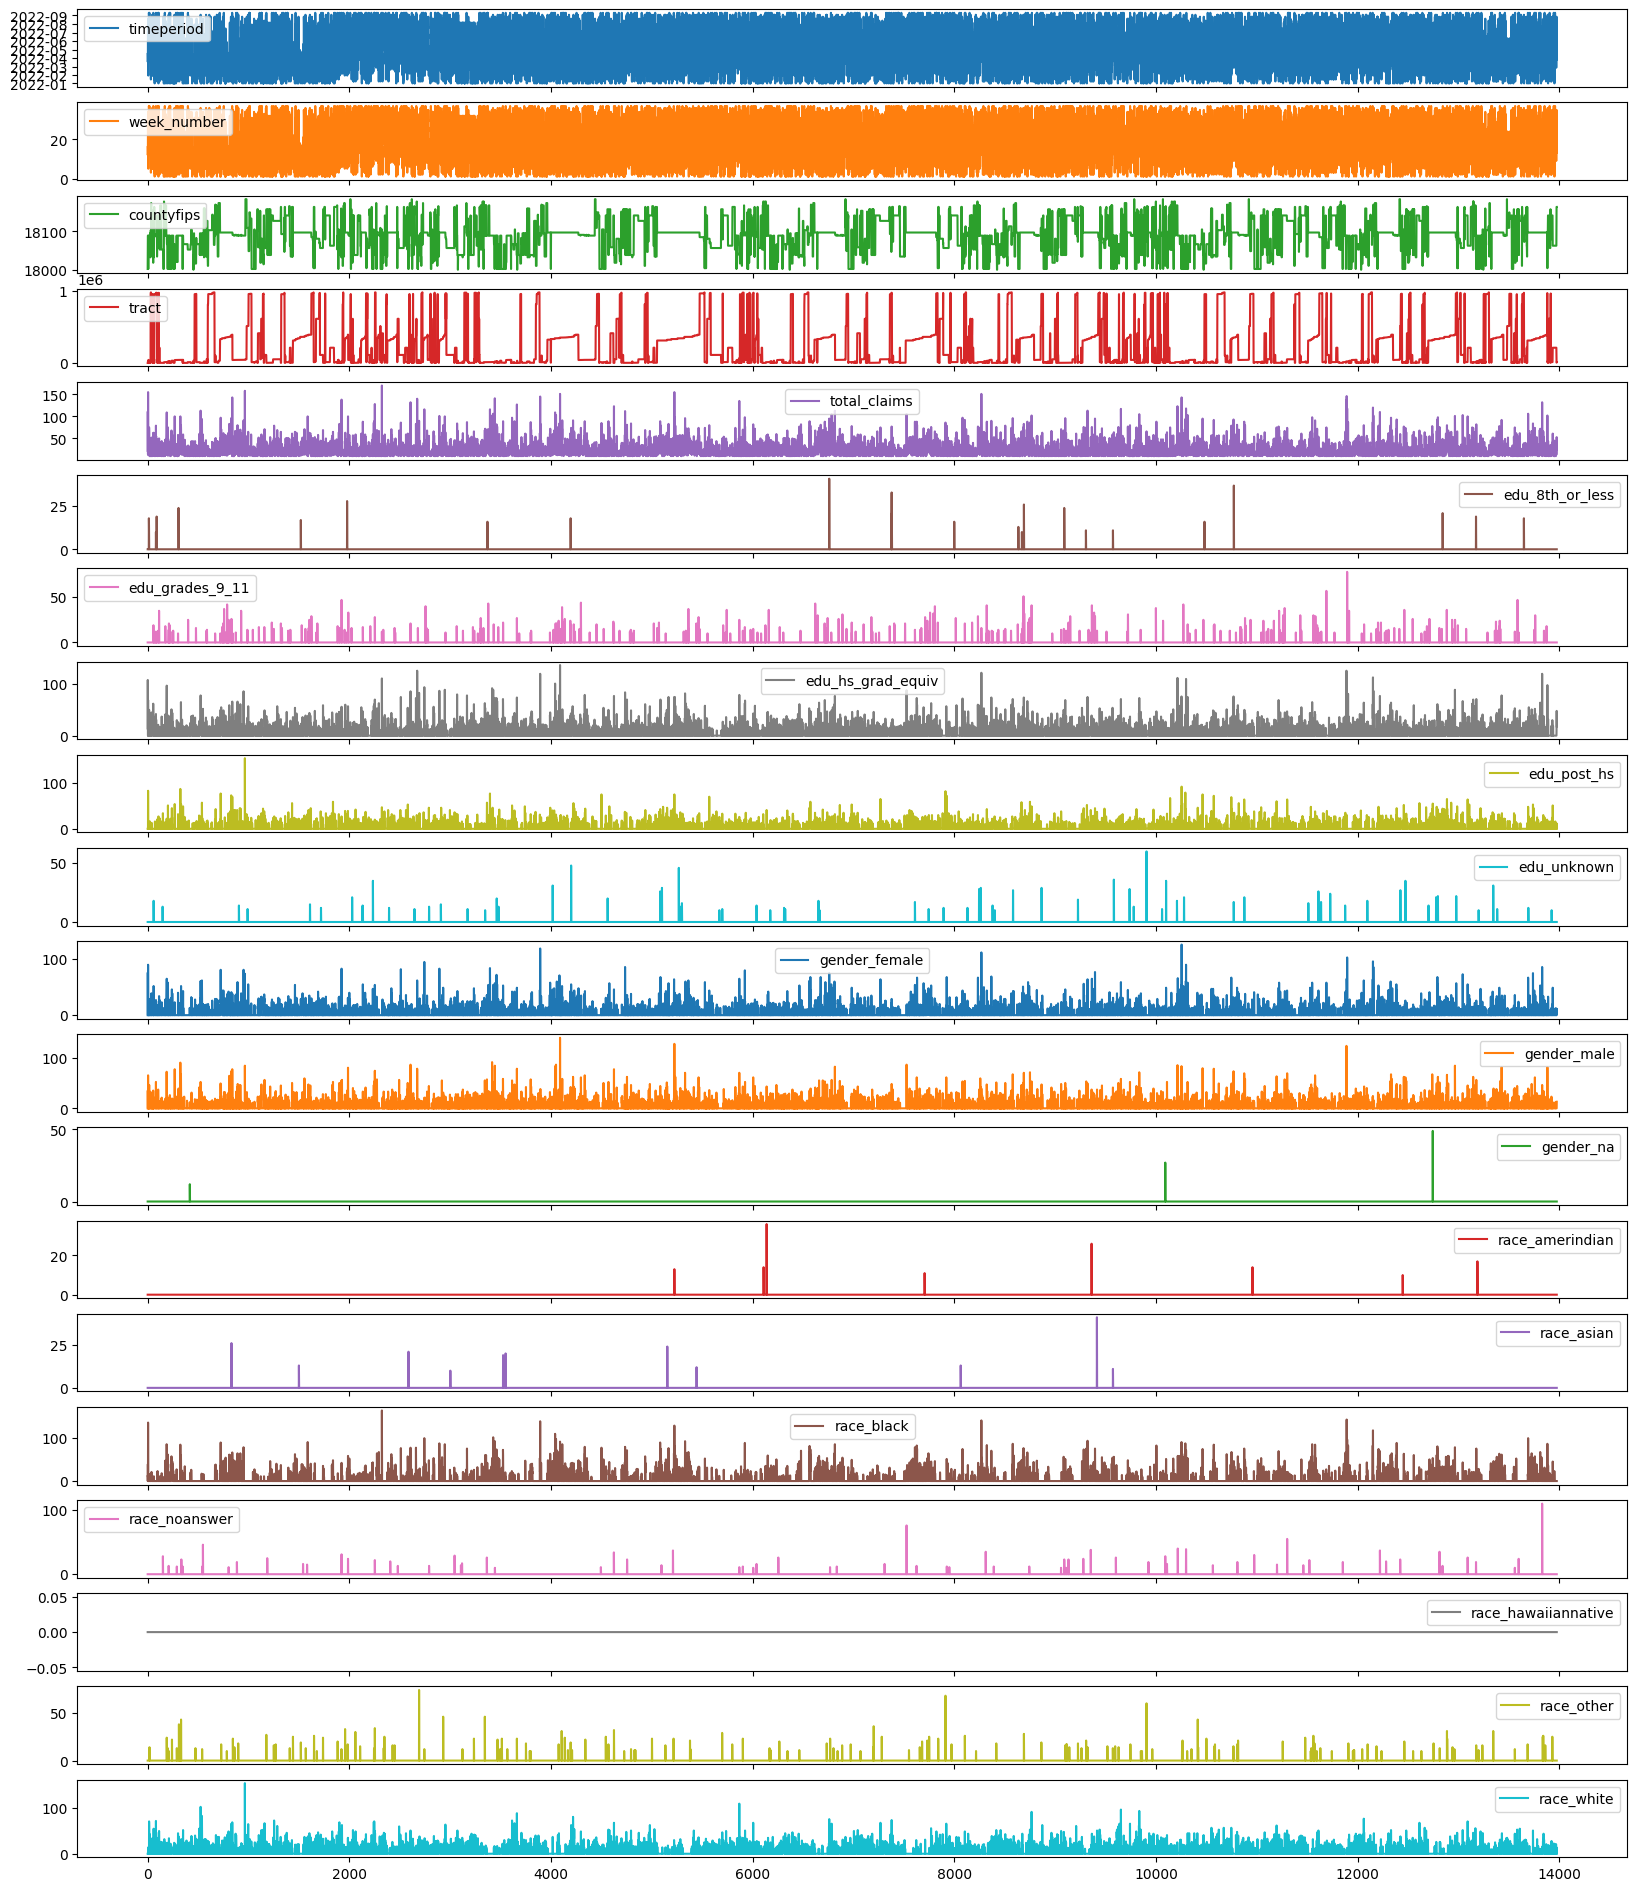

In [22]:
data.plot(subplots=True, figsize=(20,24))

In [23]:
min(data['timeperiod']),max(data['timeperiod'])

(Timestamp('2022-01-01 00:00:00'), Timestamp('2022-09-10 00:00:00'))

In [24]:
data.dtypes

uu_id                             object
timeperiod                datetime64[ns]
week_number                        Int64
countyfips                         Int64
tract                              Int64
tract_name                        object
total_claims                       Int64
edu_8th_or_less                    Int64
edu_grades_9_11                    Int64
edu_hs_grad_equiv                  Int64
edu_post_hs                        Int64
edu_unknown                        Int64
top_category_employer1            object
top_category_employer2            object
top_category_employer3            object
gender_female                      Int64
gender_male                        Int64
gender_na                          Int64
race_amerindian                    Int64
race_asian                         Int64
race_black                         Int64
race_noanswer                      Int64
race_hawaiiannative                Int64
race_other                         Int64
race_white      

data = data.set_index('timeperiod')

In [25]:
data.index

RangeIndex(start=0, stop=13977, step=1)

data['Year'] = data.index.year
data['Month'] = data.index.month
data['Day'] = data.index.day
Display a random sampling of 5 rows
data.sample(5, random_state=0)

In [26]:
sns.set(rc={'figure.figsize':(11, 4)})

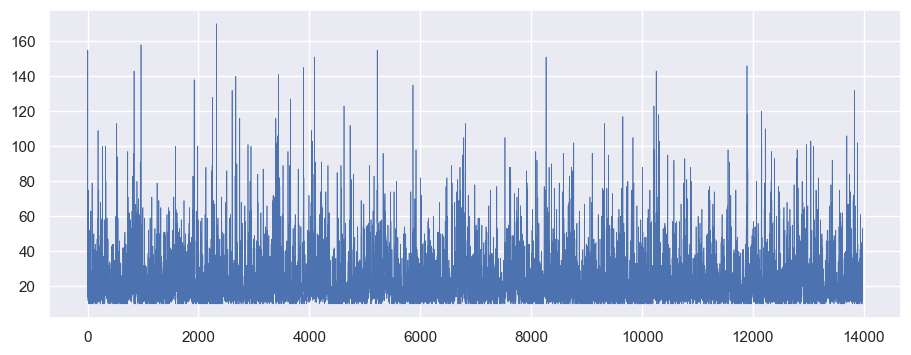

In [27]:
data['total_claims'].plot(linewidth=.5);

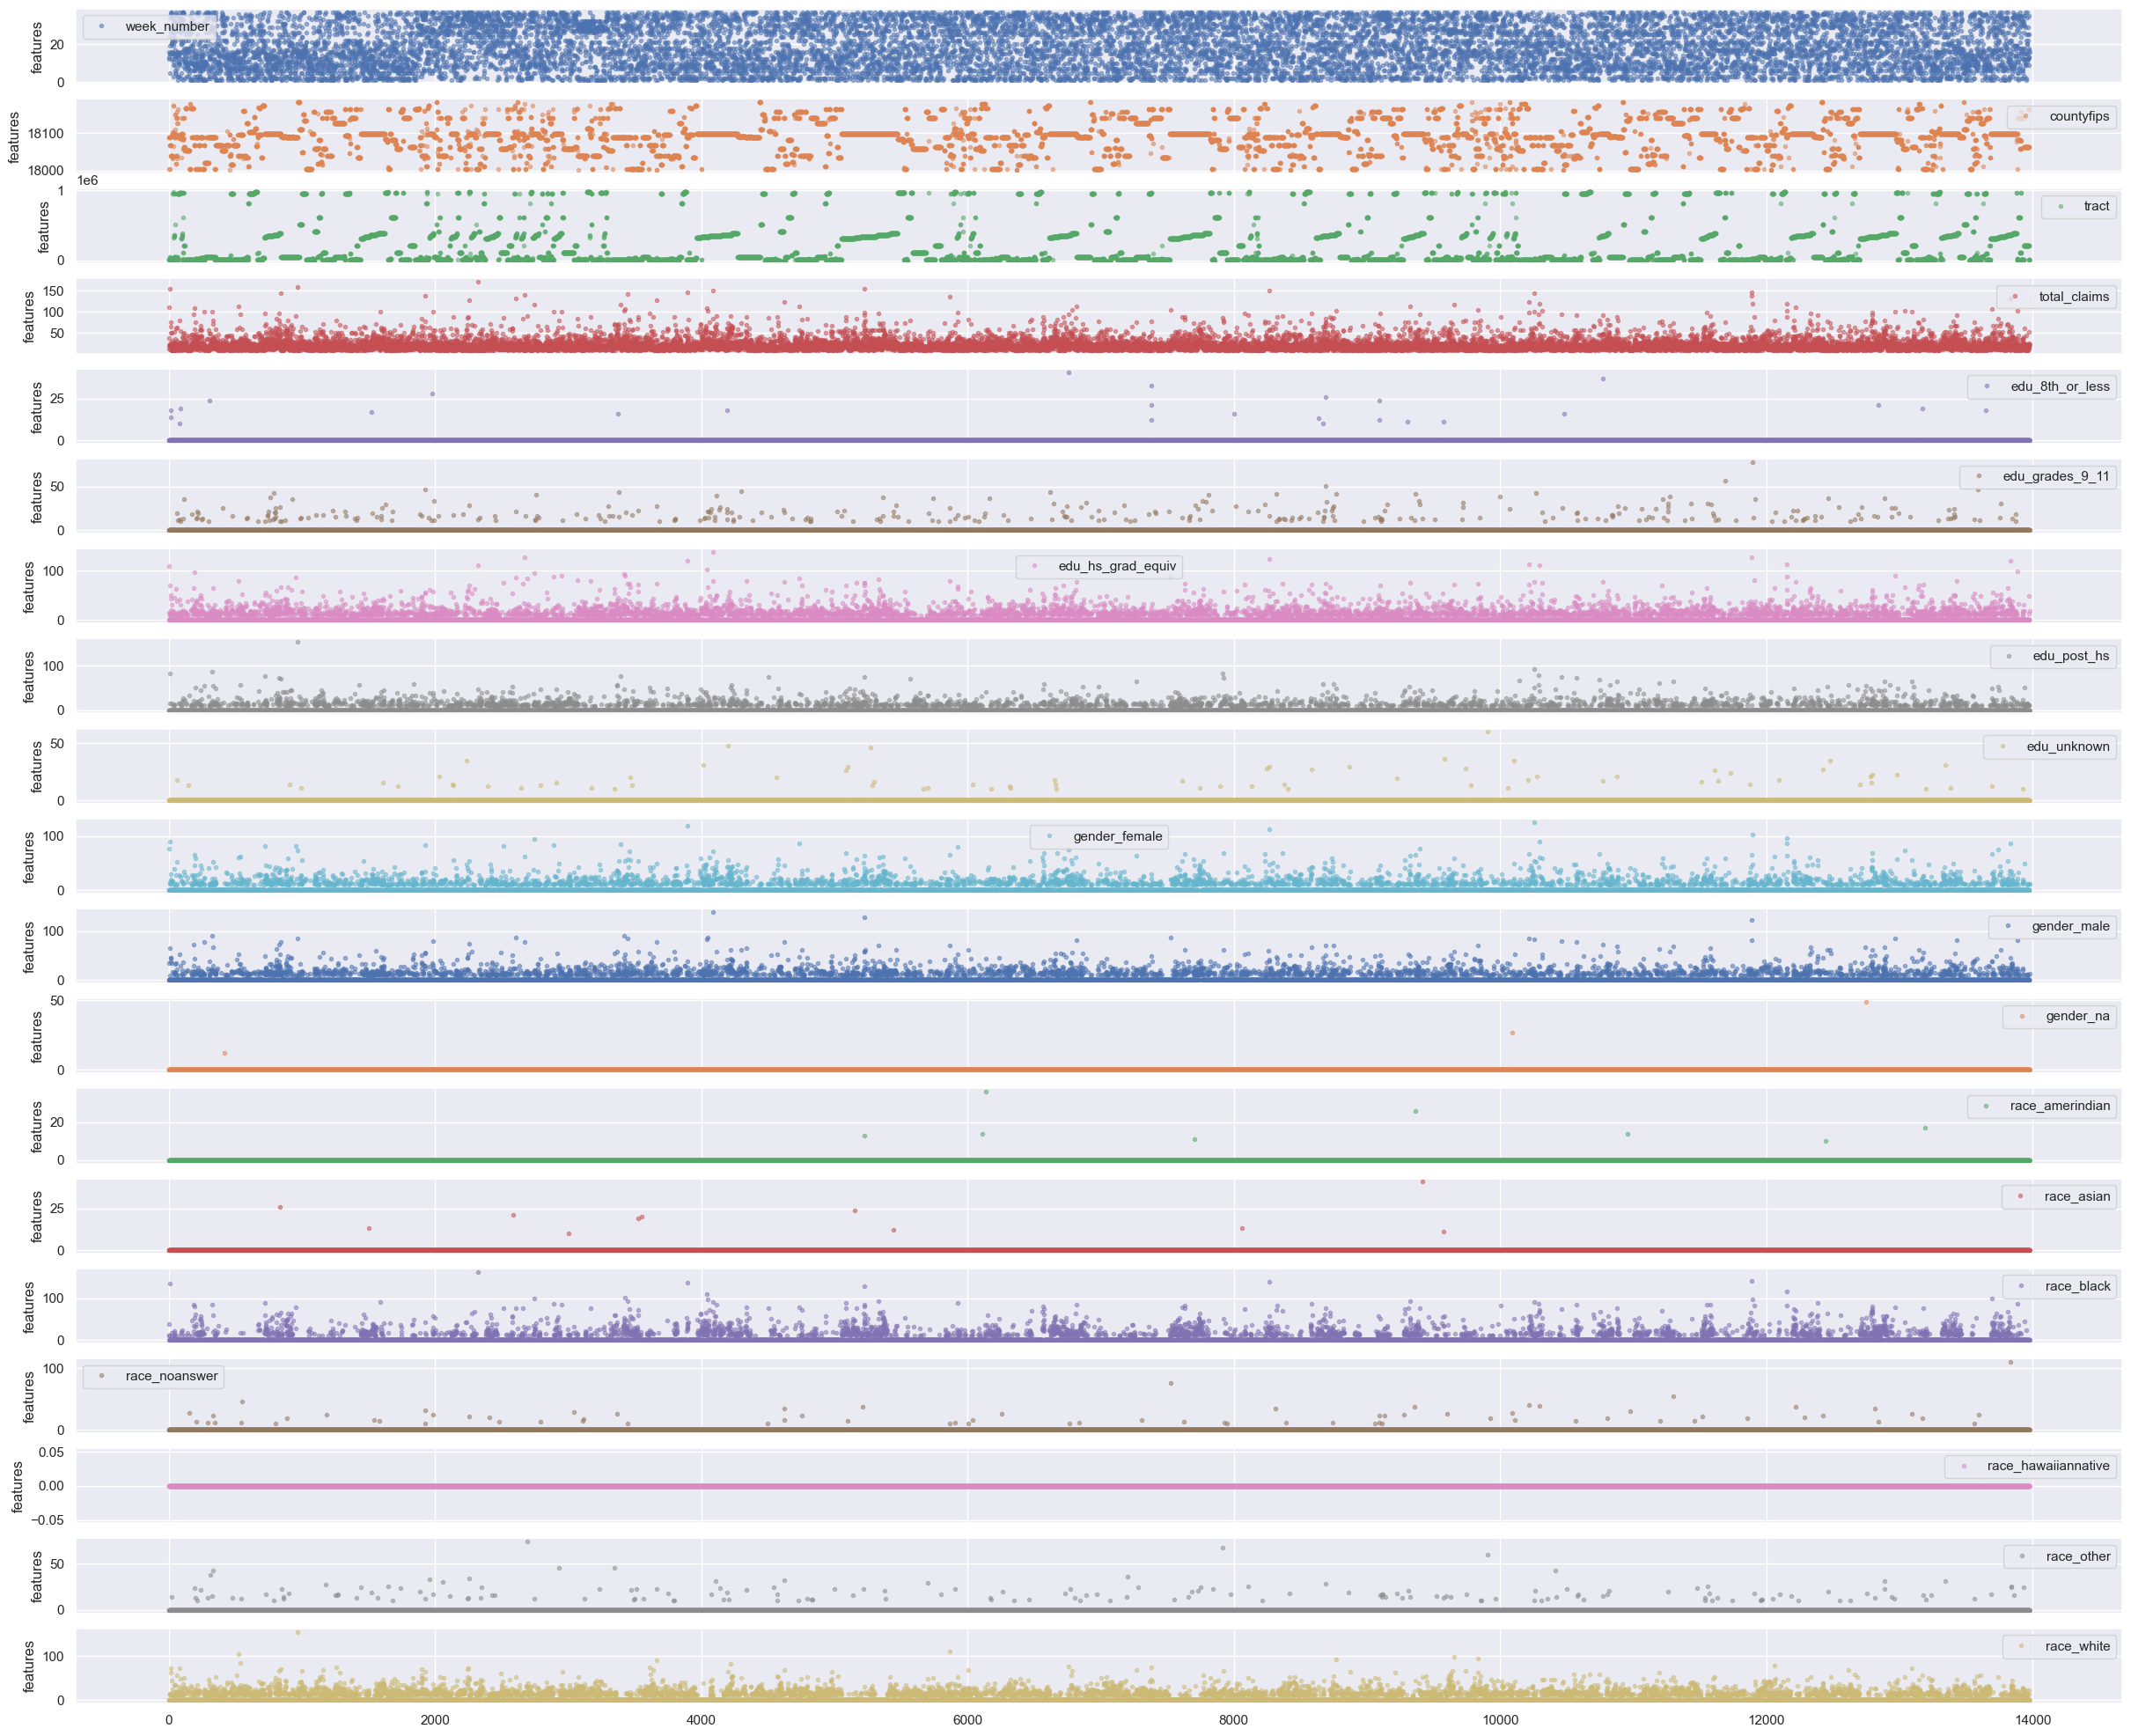

In [28]:
cols_plot = ['week_number','countyfips','tract','total_claims','edu_8th_or_less','edu_grades_9_11','edu_hs_grad_equiv','edu_post_hs',
            'edu_unknown', 'gender_female', 'gender_male', 'gender_na', 'race_amerindian', 'race_asian', 'race_black', 'race_noanswer', 
            'race_hawaiiannative', 'race_other', 'race_white']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(30, 25), subplots=True)
for ax in axes:
    ax.set_ylabel('features')

import matplotlib.dates as mdates
fig, ax = plt.subplots()
ax.plot(data.loc['2019-08':'2019-12', 'precipitation_data'], marker='o', linestyle='-')
ax.set_ylabel('Precipitation')
ax.set_title('Aug 2019-2020 Precipiation Data')

In [29]:
#fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
#for name, ax in zip(['precipitation_data', 'min_temperature', 'max_temperature'], axes):
#    sns.boxplot(data=data, x='Month', y=name, ax=ax)
#    ax.set_ylabel('precipitation')
#    ax.set_title(name)
    # Remove the automatic x-axis label from all but the bottom subplot
#    if ax != axes[-1]:
#        ax.set_xlabel('')

sns.boxplot(data=data, x='Month', y='total_claims');

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(x=data['max_temperature'], lags=50)

In [30]:
columns_rel.append('timeperiod')
columns_rel.append('uu_id')
columns_rel

['total_claims',
 'edu_grades_9_11',
 'edu_hs_grad_equiv',
 'edu_post_hs',
 'gender_female',
 'gender_male',
 'race_black',
 'race_white',
 'timeperiod',
 'uu_id']

In [31]:
data

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
0,f013068de98db1470bd986137a0c6d23,2022-04-16,16,18003,900,"Census Tract 9, Allen County, Indiana",22,0,0,14,...,0,0,0,0,0,11,0,0,0,0
1,21957d5517323845818d87623589e1ba,2022-03-19,12,18089,10400,"Census Tract 104, Lake County, Indiana",111,0,0,108,...,76,35,0,0,0,0,0,0,0,0
2,6a5609f385912113b6f1014b958ed748,2022-03-26,13,18089,11500,"Census Tract 115, Lake County, Indiana",39,0,0,0,...,0,0,0,0,0,39,0,0,0,0
3,46b2882ec4c373527ec33f7bd4f1388d,2022-07-16,29,18089,20700,"Census Tract 207, Lake County, Indiana",14,0,0,0,...,0,0,0,0,0,10,0,0,0,0
4,37495d17e82f7df326bfc2c4c090f7b7,2022-04-09,15,18089,21900,"Census Tract 219, Lake County, Indiana",155,0,0,69,...,90,65,0,0,0,135,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,6d4dc6590c52c9b265d5003bf90ddbbb,2022-04-23,17,18063,210607,"Census Tract 2106.07, Hendricks County, Indiana",13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13973,f35320206f3dd1ffc411e4ac127caf92,2022-06-18,25,18163,3804,"Census Tract 38.04, Vanderburgh County, Indiana",21,0,0,0,...,0,0,0,0,0,0,0,0,0,14
13974,f35320206f3dd1ffc411e4ac127caf92,2022-08-27,35,18163,3804,"Census Tract 38.04, Vanderburgh County, Indiana",22,0,0,13,...,0,0,0,0,0,0,0,0,0,0
13975,bbcb018f0e5e49e13636f6e78ce9f60f,2022-03-26,13,18163,10203,"Census Tract 102.03, Vanderburgh County, Indiana",53,0,0,48,...,0,0,0,0,0,0,0,0,0,0


In [32]:
data_arima=data[columns_rel]
data_arima

,total_claims,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,gender_female,gender_male,race_black,race_white,timeperiod,uu_id
0,22,0,14,0,0,0,11,0,2022-04-16,f013068de98db1470bd986137a0c6d23
1,111,0,108,0,76,35,0,0,2022-03-19,21957d5517323845818d87623589e1ba
2,39,0,0,0,0,0,39,0,2022-03-26,6a5609f385912113b6f1014b958ed748
3,14,0,0,0,0,0,10,0,2022-07-16,46b2882ec4c373527ec33f7bd4f1388d
4,155,0,69,83,90,65,135,0,2022-04-09,37495d17e82f7df326bfc2c4c090f7b7
...,...,...,...,...,...,...,...,...,...,...
13972,13,0,0,0,0,0,0,0,2022-04-23,6d4dc6590c52c9b265d5003bf90ddbbb
13973,21,0,0,12,0,0,0,14,2022-06-18,f35320206f3dd1ffc411e4ac127caf92
13974,22,0,13,0,0,0,0,0,2022-08-27,f35320206f3dd1ffc411e4ac127caf92
13975,53,0,48,0,0,0,0,0,2022-03-26,bbcb018f0e5e49e13636f6e78ce9f60f


In [33]:
get_ipython().run_cell_magic('capture', '', "unique_id=list(data_arima['uu_id'].unique())\ndata_dict = {}\n\nfor i in unique_id:\n    j = data_arima[data_arima['uu_id']==i].groupby('timeperiod')['total_claims'].sum().reset_index()\n    j = j.set_index('timeperiod')\n    data_dict[i] = j\n")

In [34]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [35]:
import warnings
warnings.filterwarnings("ignore")

In [36]:
result_dict = {}
param_dict = {}
seasonal_dict = {}
for key in data_dict:
    y=data_dict[key]['total_claims']
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            
            try:
                
                mod = sm.tsa.statespace.SARIMAX(y.astype(float),
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                result_dict[key] = mod.fit(disp=False)
                #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, result_dict[key].aic))
                param_dict[key]=param
                seasonal_dict[key]=param_seasonal
            except:
                continue

In [ ]:
param_dict_copy=param_dict
seasonal_dict_copy=seasonal_dict
result_dict_copy=result_dict

In [ ]:
results = {}
for key in data_dict:
    y=data_dict[key]['total_claims']
    print(y)
    mod = sm.tsa.statespace.SARIMAX(y.astype(float),
                                order=param_dict[key],
                                seasonal_order=seasonal_dict[key],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results[key] = mod.fit(disp=False)
    #print(results.summary().tables[1])